## Open and pre-select data

In [11]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*
#Open Zmumu file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Set event range
nmin1=0
nmax1=3000

#Choose quality 0
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Open ZeroBias file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/zbV3_skim.root") 
MuonTree_ZeroBias=file["MuonTree;1"]

#Apply energy cut to offline
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

#Get online data
Zbl1_pt=MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta=MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi=MuonTree_ZeroBias["LVL1Muon_phi"].array()

#Create mask matching offline and LVL1
mask=offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi, dr_threshold=0.4)

#Apply mask
ZeroBias_pt=ZeroBias_pt[mask]
ZeroBias_eta=ZeroBias_eta[mask]
ZeroBias_phi=ZeroBias_phi[mask]

100%|██████████| 3000/3000 [00:04<00:00, 682.86it/s]
494957it [02:03, 4007.13it/s]


## Plot pt, eta, phi

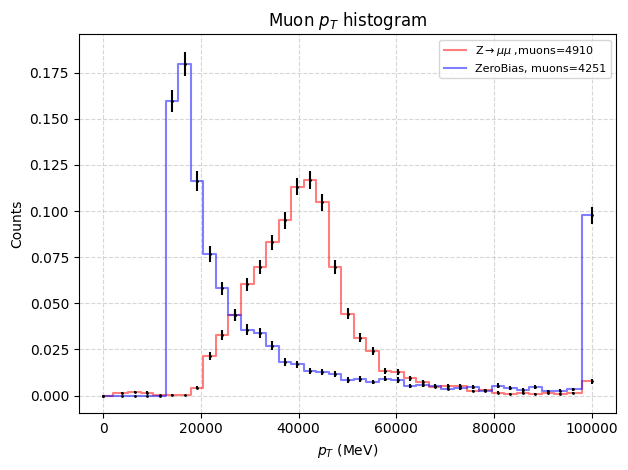

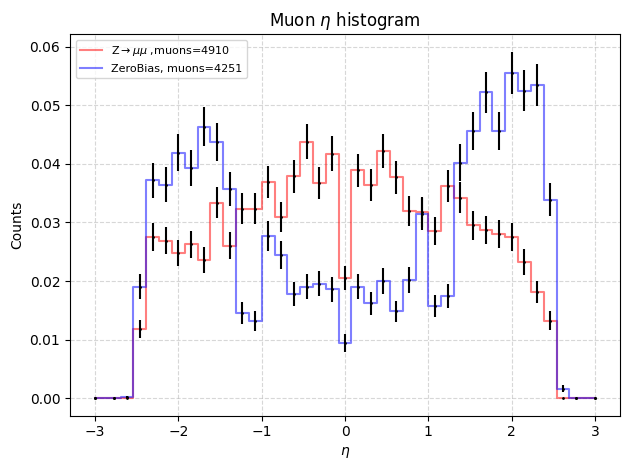

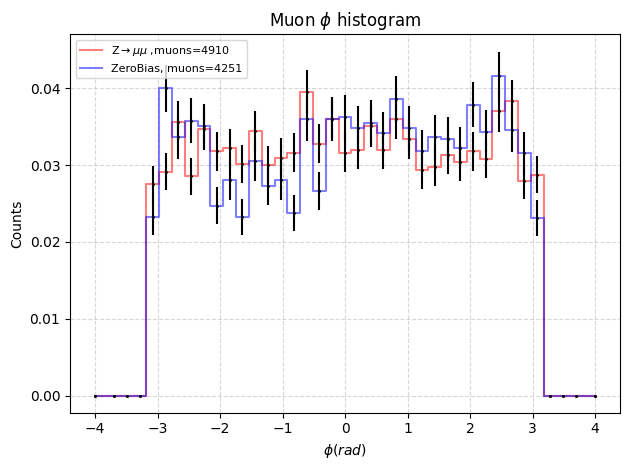

In [7]:
l1=len(ak.flatten(Zmumu_pt))
l2=len(ak.flatten(ZeroBias_pt))
coolplot([Zmumu_pt, ZeroBias_pt], np.linspace(0,10*10**4, 40),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title="Muon $p_T$ histogram", x_label=r"$p_T$ (MeV)", y_label="Counts", plot_show=False)
plt.savefig('pt_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_eta, ZeroBias_eta], np.linspace(-3,3, 40),
         labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\eta$ histogram", x_label=r"$\eta$", y_label="Counts", plot_show=False)
plt.savefig('eta_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_phi, ZeroBias_phi], np.linspace(-4,4, 40),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\phi$ histogram",  x_label=r"$\phi (rad)$", y_label="Counts", plot_show=False)
plt.savefig('phi_hist.pdf', format='pdf')
plt.show()

## Compute and plot isolation

Computing for dr= [0.1, 0.2] ... 1 ouf of 6


Computing for dr= [0.1, 0.3] ... 2 ouf of 6


Computing for dr= [0.1, 0.4] ... 3 ouf of 6


Computing for dr= [0.1, 0.6] ... 4 ouf of 6


Computing for dr= [0.1, 0.8] ... 5 ouf of 6


Computing for dr= [0.1, 1.0] ... 6 ouf of 6


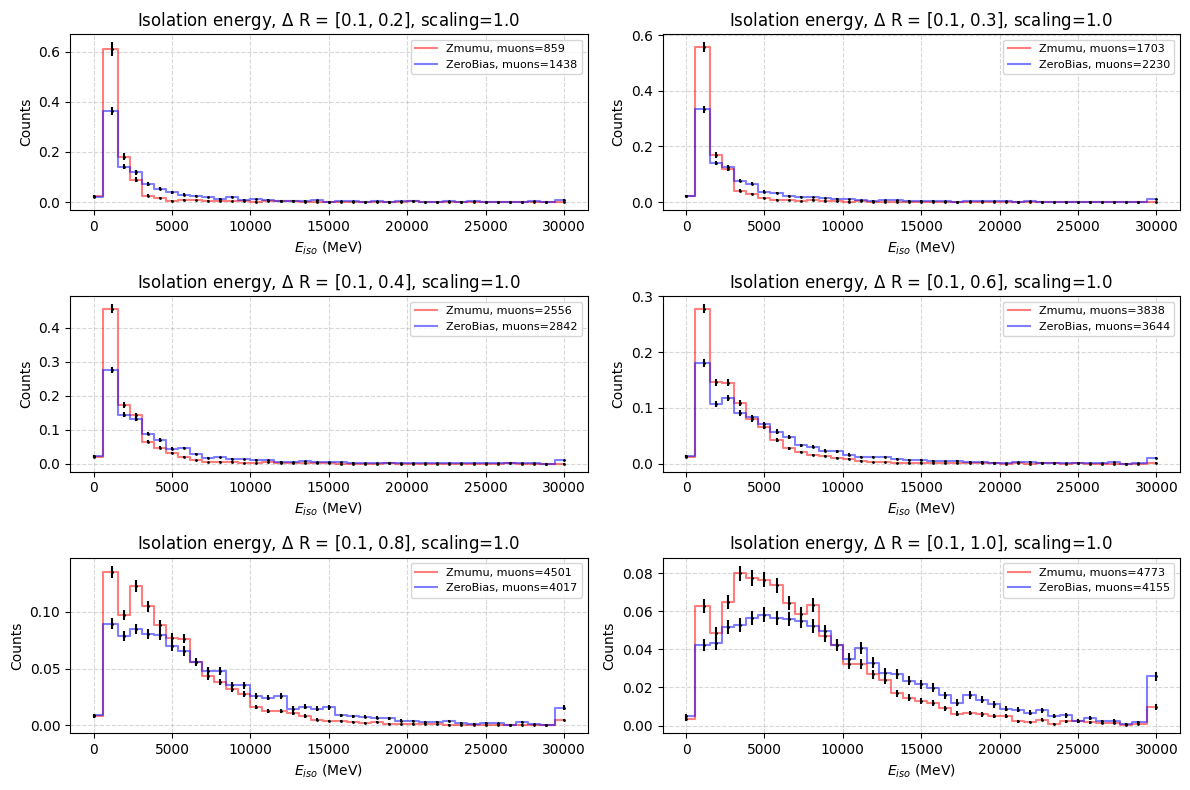

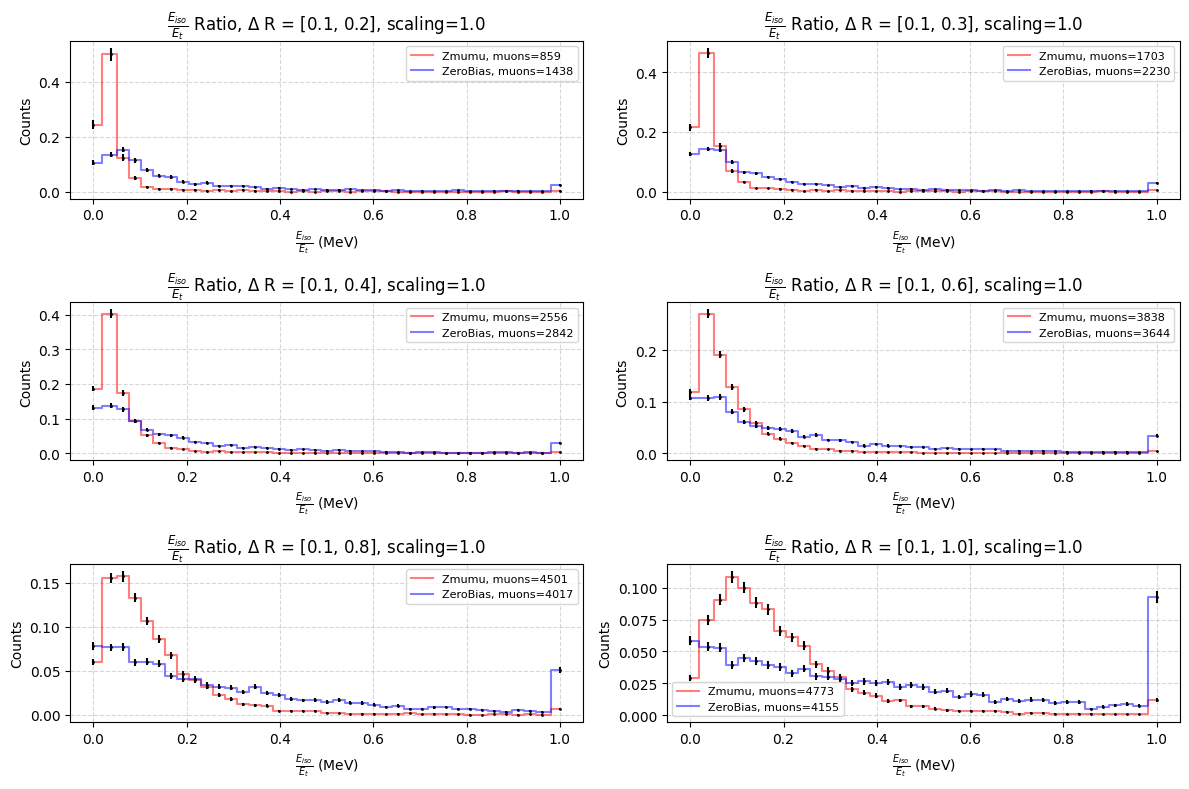

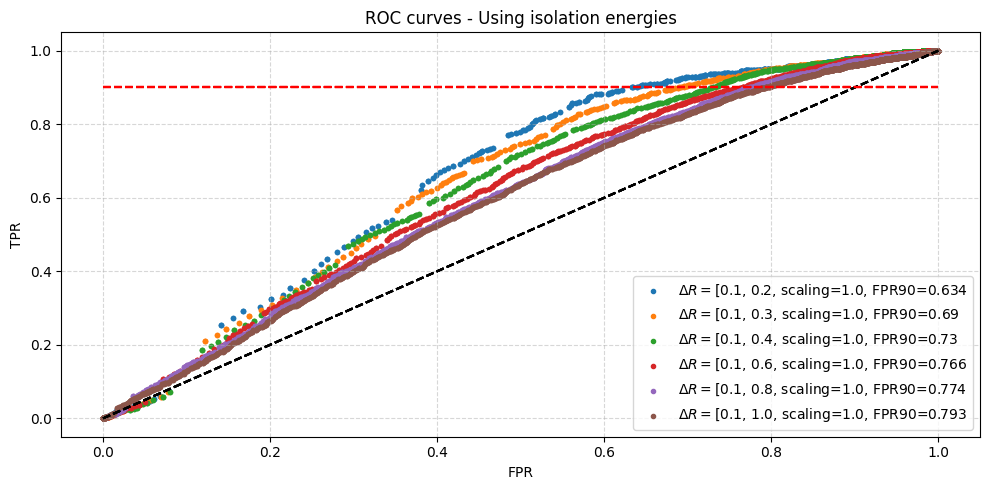

In [8]:
fig2, axis2 = plt.subplots(3, 2, figsize=(12, 8))
fig3, axis3 = plt.subplots(3, 2, figsize=(12, 8))
fig4, axis4 = plt.subplots(1, 1, figsize=(10, 5))
#Set delta R - array length must be even in order to display subplots nicely
dr_mins=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dr_maxs=[0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
#Set noise cut scaling factors
scalings=1.0

for i in range(len(dr_mins)):  
    print("Computing for dr=",[dr_mins[i],dr_maxs[i]],"...", i+1,"ouf of",len(dr_mins))
    dr_min=dr_mins[i]
    dr_max=dr_maxs[i]
    #Compute isolation energy
    res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                    event_range=[nmin1, nmax1], scaling=scalings)
    res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                event_range=[0, len(ZeroBias_eta)], scaling=scalings)
    #Plot it
    bins=np.linspace(0,30*10**3,40)
    row, col = divmod(i, 2)
    ax = axis2[row][col]

    aux=ak.flatten(res1)
    l1=len(aux[~np.isnan(aux)])
    aux=ak.flatten(res2)
    l2=len(aux[~np.isnan(aux)])

    coolplot(
        [res1, res2],
        bins=bins,
        labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
        x_label=r"$E_{iso}$ (MeV)",
        y_label="Counts",
        title=fr"Isolation energy, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings}",
        ax=ax)

    #Compute ratios
    fig2.tight_layout()
    ratio1=ak.flatten(res1)/ak.flatten(Zmumu_pt)
    ratio1=ratio1[~np.isnan(ratio1)]
    l1=len(ratio1)

    ratio2=ak.flatten(res2)/ak.flatten(ZeroBias_pt)
    ratio2=ratio2[~np.isnan(ratio2)]
    l2=len(ratio2)

    #Plot them
    bins=np.linspace(0,1.0,40)
    row, col = divmod(i, 2)
    ax = axis3[row][col]
    
    coolplot(
    [ratio1, ratio2],
    bins=bins,
    labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
    x_label=r"$\frac{E_{iso}}{E_{t}}$ (MeV)",
    y_label="Counts",
    title=fr"$\frac{{E_{{iso}}}}{{E_{{t}}}}$ Ratio, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings}",
    ax=ax)

    fig3.tight_layout()

    #Compute ROC
    bins=np.linspace(0,40000,4000)

    data1=ak.flatten(res1)
    data1=data1[~np.isnan(data1)]
    data2=ak.flatten(res2)
    data2=data2[~np.isnan(data2)]
    Zmumu_counts, _ = np.histogram(data1, bins)
    ZeroBias_counts, _ = np.histogram(data2, bins)
    #Compute the cumulative sum of the counts (like integrating the histogram to the left)
    Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
    ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
    # Normalize to total events
    TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
    FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

    #Plot ROC
    FPR90=min(FPR[TPR >= 0.9])
    ax=axis4
    plt.scatter(FPR, TPR, marker='.', label=fr'$\Delta R=$[{dr_min}, {dr_max}, scaling={scalings}, FPR90={np.round(FPR90,3)}')
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title(rf"ROC curves - Using isolation energies")
    plt.tight_layout()

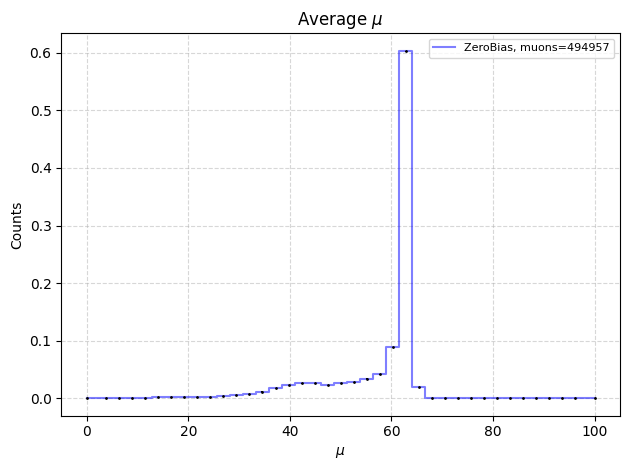

In [9]:
mu=MuonTree_ZeroBias["AverageMu"].array()
l=len(ak.flatten(mu))
coolplot([mu], np.linspace(0,100,40), labels=[f"ZeroBias, muons={l}"],
          title=r"Average $\mu$", x_label=r"$\mu$", y_label="Counts", colors=['b'], plot_show=False)
plt.savefig(f'average_mu.pdf', format='pdf')
plt.show()

In [ ]:
##################################################################################################################################33
points=5
iterations=1
next_dr_mins=np.linspace(0,0.20,points)
next_dr_maxs=np.linspace(0.20,1.0,points)

min_range=[min(next_dr_mins), max(next_dr_mins)]
max_range=[min(next_dr_maxs), max(next_dr_maxs)]

FPR_effs, dr_mins, dr_maxs= ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, [nmin1,nmax1], [0, len(ZeroBias_pt)], min_range, max_range, points, bins=np.linspace(0,2,1000), scaling=1.0)

FPR_effs_not_none=FPR_effs[FPR_effs != None]

#Get flat position the first 5 indices of the sorted array
flat_indices = np.argsort(FPR_effs_not_none, axis=None)[:5] 
#Arrange them into 2D coordinates
positions = np.unravel_index(flat_indices, FPR_effs.shape) 
#Create list of respective pairs 
best_coords = list(zip(positions[0], positions[1]))
#Print and prepare next iteration
next_dr_mins=[]
next_dr_maxs=[]
print("Top 5 lowest FPR(90%):")
for i, (row, col) in enumerate(best_coords):
    print(fr"{i+1}. ΔR = [{dr_mins[row]}, {dr_maxs[col]}] → FPR = {FPR_effs[row, col]}")
    next_dr_mins.append(dr_mins[row])
    next_dr_maxs.append(dr_maxs[col])

Step 1 out of 25


Step 2 out of 25


Step 3 out of 25


muon_isolation_all_events: Computing muon isolation:   0%|          | 0/50 [00:00<?, ?it/s]       

In [ ]:
##################################################################################################################################33
points=5
iterations=1
next_dr_mins=np.linspace(0,0.20,points)
next_dr_maxs=np.linspace(0.20,1.0,points)

min_range=[min(next_dr_mins), max(next_dr_mins)]
max_range=[min(next_dr_maxs), max(next_dr_maxs)]

FPR_effs, dr_mins, dr_maxs= ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, [nmin1,nmax1], [0, len(ZeroBias_pt)],
                   min_range, max_range, points, bins=np.linspace(0,50000,5000), scaling=1.0, use_ratio=False)

FPR_effs_not_none=FPR_effs[FPR_effs != None]

#Get flat position the first 5 indices of the sorted array
flat_indices = np.argsort(FPR_effs_not_none, axis=None)[:5] 
#Arrange them into 2D coordinates
positions = np.unravel_index(flat_indices, FPR_effs.shape) 
#Create list of respective pairs 
best_coords = list(zip(positions[0], positions[1]))
#Print and prepare next iteration
next_dr_mins=[]
next_dr_maxs=[]
print("Top 5 lowest FPR(90%):")
for i, (row, col) in enumerate(best_coords):
    print(fr"{i+1}. ΔR = [{dr_mins[row]}, {dr_maxs[col]}] → FPR = {FPR_effs[row, col]}")
    next_dr_mins.append(dr_mins[row])
    next_dr_maxs.append(dr_maxs[col])